## Description
In this notebook, I attempted the problem with huggingface's ALBERT MLM model, trying to figure out if it's possible to make use of transformer based models for time series data.  
I managed to train a model with my two 1070ti for about 40 hrs, the final training loss is around 0.23, and eval loss is around 0.26, and the curve is still going down.  
Training big models is super time consuming, so I will only share the code and resulting training curve I have here for people who are interested in exploring transformers based models.  


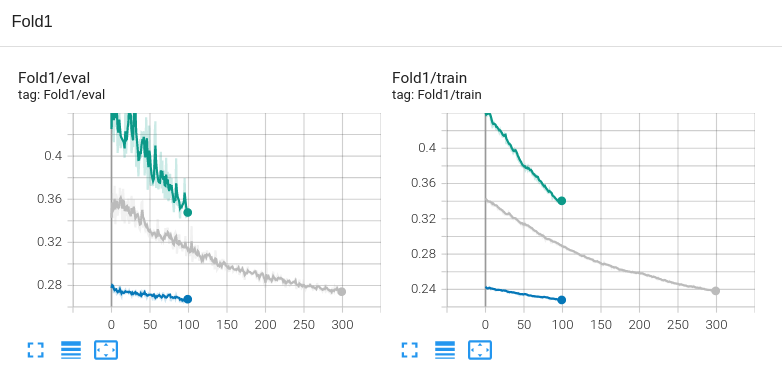

## Data preparation

Data preparation is similar to many of the open notebooks here in this competition

In [ ]:
import numpy as np
import pandas as pd
import torch
import math
import time
import os
from tqdm import tqdm

from torch import nn
from transformers.utils import logging
from transformers.activations import ACT2FN
from transformers.modeling_utils import (
    PreTrainedModel,
    apply_chunking_to_forward,
    find_pruneable_heads_and_indices,
    prune_linear_layer,
)
from torch.utils.tensorboard import SummaryWriter

from transformers import AlbertConfig
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold

DATA_PATH = "../input/ventilator-pressure-prediction/"

DEBUG = False

if DEBUG == True:
    train = pd.read_csv(DATA_PATH+'train.csv').head(24000)
    test = pd.read_csv(DATA_PATH+'test.csv').head(16000)
    submission = pd.read_csv(DATA_PATH+'sample_submission.csv').head(16000)
else:
    train = pd.read_csv(DATA_PATH+'train.csv')
    test = pd.read_csv(DATA_PATH+'test.csv')
    submission = pd.read_csv(DATA_PATH+'sample_submission.csv')

    # train = train.head(train.shape[0]//10)
    # test = test.head(test.shape[0]//10)
    # submission = submission.head(submission.shape[0]//10)

def add_features(df):
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['cross']= df['u_in']*df['u_out']
    df['cross2']= df['time_step']*df['u_out']
    
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    ###
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] / df['count']
    
    ###
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lag3']=df['breath_id'].shift(3).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id_lag3same']=np.select([df['breath_id_lag3']==df['breath_id']],[1],0)
    df['u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['u_in_lag'] = df['u_in_lag']*df['breath_id_lagsame']
    df['u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag2'] = df['u_in_lag2']*df['breath_id_lag2same']
    df['u_in_lag3'] = df['u_in'].shift(2).fillna(0)
    df['u_in_lag3'] = df['u_in_lag3']*df['breath_id_lag3same']
    
    df['u_out_lag2'] = df['u_out'].shift(2).fillna(0)
    df['u_out_lag2'] = df['u_out_lag2']*df['breath_id_lag2same']
    df['u_out_d'] = df['u_out'].diff().fillna(0)
    
    df['u_sum'] = df['u_in'] + df['u_out']
    
    df['ts_diff'] = df['time_step'].diff().fillna(0.033)
    df['ts_dd'] = df['ts_diff'].diff().fillna(0)/df['ts_diff']
    
    df['u_in_diff'] = df['u_in'].diff().fillna(0)
    df['u_in_d'] = df['u_in_diff']/df['ts_diff']
    df['u_in_d_diff'] = df['u_in_d'].diff().fillna(0)
    df['u_in_dd'] = df['u_in_d']/df['ts_diff']
    df['u_in_dd_diff'] = df['u_in_dd'].diff().fillna(0)
    
    # gives the mean of 'u_in' with column name 'u_in_y'
    df = df.merge(df.groupby('breath_id')['u_in'].mean(), left_on=['breath_id'], right_on=['breath_id'])
    df['bias'] = df['u_in_x'] - df['u_in_y']
    df['bias_diff'] = df['bias'].diff().fillna(0)
    
    df['bias_d'] = df['bias']/df['ts_diff']
    df['bias_d_diff'] = df['bias_d'].diff().fillna(0)
    #
    df['var'] = (df['u_in_x'] - df['u_in_y'])**2
    df['var_diff'] = df['var'].diff().fillna(0)
    #
    df['var_d'] = df['var']/df['ts_diff']
    df['var_d_diff'] = df['var_d'].diff().fillna(0)
    #
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['RC'] = df['R'] + df['C']
    df = pd.get_dummies(df)
    return df

train = add_features(train)
test = add_features(test)

mask_train = 1 - train[['u_out']].to_numpy().reshape(-1, 80)#[:,:33]
mask_test = 1 - test[['u_out']].to_numpy().reshape(-1, 80)#[:,:33]

targets = train[['pressure']].to_numpy().reshape(-1, 80)#[:,:33]
#targets = targets * mask_train

train.drop(['pressure', 'id', 'breath_id', 'one','count', 'u_in_y', 'breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1, inplace=True)
test.drop(['id', 'breath_id', 'one','count', 'u_in_y','breath_id_lag','breath_id_lag2','breath_id_lagsame','breath_id_lag2same','u_out_lag2'], axis=1, inplace=True)

RS = RobustScaler()
train = RS.fit_transform(train)
test = RS.transform(test)

train = train.reshape(-1, 80, train.shape[-1])#[:,:33,:]
#train = np.transpose(np.transpose(train, (2,0,1))*mask_train, (1,2,0))

test = test.reshape(-1, 80, train.shape[-1])#[:,:33,:]
#test = np.transpose(np.transpose(test, (2,0,1))*mask_test, (1,2,0))


## Model definition
Model definition is copied from huggingface transformers, with a bit tweak to adapt to timeseries data. Model does not include embedding layer,and default parameters have been largely reduced to be fit in two 8G nvidia gtx gpus.   
https://github.com/huggingface/transformers/blob/master/src/transformers/models/albert/modeling_albert.py

In [ ]:

class AlbertAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads}"
            )

        self.num_attention_heads = config.num_attention_heads
        self.hidden_size = config.hidden_size
        self.attention_head_size = config.hidden_size // config.num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.attention_dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.output_dropout = nn.Dropout(config.hidden_dropout_prob)
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.pruned_heads = set()

        self.position_embedding_type = getattr(config, "position_embedding_type", "absolute")
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

    # Copied from transformers.models.bert.modeling_bert.BertSelfAttention.transpose_for_scores
    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.num_attention_heads, self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.query = prune_linear_layer(self.query, index)
        self.key = prune_linear_layer(self.key, index)
        self.value = prune_linear_layer(self.value, index)
        self.dense = prune_linear_layer(self.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.num_attention_heads = self.num_attention_heads - len(heads)
        self.all_head_size = self.attention_head_size * self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(self, hidden_states, attention_mask=None, head_mask=None, output_attentions=False):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            seq_length = hidden_states.size()[1]
            position_ids_l = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(seq_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r
            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.attention_dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.transpose(2, 1).flatten(2)

        projected_context_layer = self.dense(context_layer)
        projected_context_layer_dropout = self.output_dropout(projected_context_layer)
        layernormed_context_layer = self.LayerNorm(hidden_states + projected_context_layer_dropout)
        return (layernormed_context_layer, attention_probs) if output_attentions else (layernormed_context_layer,)

class AlbertLayer(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        self.chunk_size_feed_forward = config.chunk_size_feed_forward
        self.seq_len_dim = 1
        self.full_layer_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.attention = AlbertAttention(config)
        self.ffn = nn.Linear(config.hidden_size, config.intermediate_size)
        self.ffn_output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.activation = ACT2FN[config.hidden_act]
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(
        self, hidden_states, attention_mask=None, head_mask=None, output_attentions=False, output_hidden_states=False
    ):
        attention_output = self.attention(hidden_states, attention_mask, head_mask, output_attentions)

        ffn_output = apply_chunking_to_forward(
            self.ff_chunk,
            self.chunk_size_feed_forward,
            self.seq_len_dim,
            attention_output[0],
        )
        hidden_states = self.full_layer_layer_norm(ffn_output + attention_output[0])

        return (hidden_states,) + attention_output[1:]  # add attentions if we output them

    def ff_chunk(self, attention_output):
        ffn_output = self.ffn(attention_output)
        ffn_output = self.activation(ffn_output)
        ffn_output = self.ffn_output(ffn_output)
        return ffn_output

class AlbertLayerGroup(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.albert_layers = nn.ModuleList([AlbertLayer(config) for _ in range(config.inner_group_num)])

    def forward(
        self, hidden_states, attention_mask=None, head_mask=None, output_attentions=False, output_hidden_states=False
    ):
        layer_hidden_states = ()
        layer_attentions = ()

        for layer_index, albert_layer in enumerate(self.albert_layers):
            layer_output = albert_layer(hidden_states, attention_mask, head_mask[layer_index], output_attentions)
            hidden_states = layer_output[0]

            if output_attentions:
                layer_attentions = layer_attentions + (layer_output[1],)

            if output_hidden_states:
                layer_hidden_states = layer_hidden_states + (hidden_states,)

        outputs = (hidden_states,)
        if output_hidden_states:
            outputs = outputs + (layer_hidden_states,)
        if output_attentions:
            outputs = outputs + (layer_attentions,)
        return outputs  # last-layer hidden state, (layer hidden states), (layer attentions)

class AlbertTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.config = config
        self.embedding_hidden_mapping_in = nn.Linear(config.embedding_size, config.hidden_size)
        self.albert_layer_groups = nn.ModuleList([AlbertLayerGroup(config) for _ in range(config.num_hidden_groups)])

        self.logits = nn.Linear(config.hidden_size, config.hidden_size)
        #self.logits_act = nn.Tanh()

    def forward(
        self,
        hidden_states,
        attention_mask=None,
        head_mask=None,
        output_attentions=False,
        output_hidden_states=False,
        return_dict=True,
    ):
        hidden_states = self.embedding_hidden_mapping_in(hidden_states)

        all_hidden_states = (hidden_states,) if output_hidden_states else None
        all_attentions = () if output_attentions else None

        head_mask = [None] * self.config.num_hidden_layers if head_mask is None else head_mask

        for i in range(self.config.num_hidden_layers):
            # Number of layers in a hidden group
            layers_per_group = int(self.config.num_hidden_layers / self.config.num_hidden_groups)

            # Index of the hidden group
            group_idx = int(i / (self.config.num_hidden_layers / self.config.num_hidden_groups))

            layer_group_output = self.albert_layer_groups[group_idx](
                hidden_states,
                attention_mask,
                head_mask[group_idx * layers_per_group : (group_idx + 1) * layers_per_group],
                output_attentions,
                output_hidden_states,
            )
            hidden_states = layer_group_output[0]

            if output_attentions:
                all_attentions = all_attentions + layer_group_output[-1]

            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

        hidden_states = self.logits(hidden_states)

        #hidden_states = self.logits_act(hidden_states)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_attentions] if v is not None)

        return hidden_states, all_hidden_states, all_attentions

class AlbertPreTrainedModel(PreTrainedModel):
    config_class = AlbertConfig
    base_model_prefix = "albert"
    _keys_to_ignore_on_load_missing = [r"position_ids"]

    def _init_weights(self, module):
        """Initialize the weights."""
        if isinstance(module, nn.Linear):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

logger = logging.get_logger(__name__)
def load_tf_weights_in_albert(model, config, tf_checkpoint_path):
    """Load tf checkpoints in a pytorch model."""
    try:
        import re

        import numpy as np
        import tensorflow as tf
    except ImportError:
        logger.error(
            "Loading a TensorFlow model in PyTorch, requires TensorFlow to be installed. Please see "
            "https://www.tensorflow.org/install/ for installation instructions."
        )
        raise
    tf_path = os.path.abspath(tf_checkpoint_path)
    logger.info(f"Converting TensorFlow checkpoint from {tf_path}")
    # Load weights from TF model
    init_vars = tf.train.list_variables(tf_path)
    names = []
    arrays = []
    for name, shape in init_vars:
        logger.info(f"Loading TF weight {name} with shape {shape}")
        array = tf.train.load_variable(tf_path, name)
        names.append(name)
        arrays.append(array)

    for name, array in zip(names, arrays):
        print(name)

    for name, array in zip(names, arrays):
        original_name = name

        # If saved from the TF HUB module
        name = name.replace("module/", "")

        # Renaming and simplifying
        name = name.replace("ffn_1", "ffn")
        name = name.replace("bert/", "albert/")
        name = name.replace("attention_1", "attention")
        name = name.replace("transform/", "")
        name = name.replace("LayerNorm_1", "full_layer_layer_norm")
        name = name.replace("LayerNorm", "attention/LayerNorm")
        name = name.replace("transformer/", "")

        # The feed forward layer had an 'intermediate' step which has been abstracted away
        name = name.replace("intermediate/dense/", "")
        name = name.replace("ffn/intermediate/output/dense/", "ffn_output/")

        # ALBERT attention was split between self and output which have been abstracted away
        name = name.replace("/output/", "/")
        name = name.replace("/self/", "/")

        # The pooler is a linear layer
        name = name.replace("pooler/dense", "pooler")

        # The classifier was simplified to predictions from cls/predictions
        name = name.replace("cls/predictions", "predictions")
        name = name.replace("predictions/attention", "predictions")

        # Naming was changed to be more explicit
        name = name.replace("embeddings/attention", "embeddings")
        name = name.replace("inner_group_", "albert_layers/")
        name = name.replace("group_", "albert_layer_groups/")

        # Classifier
        if len(name.split("/")) == 1 and ("output_bias" in name or "output_weights" in name):
            name = "classifier/" + name

        # No ALBERT model currently handles the next sentence prediction task
        if "seq_relationship" in name:
            name = name.replace("seq_relationship/output_", "sop_classifier/classifier/")
            name = name.replace("weights", "weight")

        name = name.split("/")

        # Ignore the gradients applied by the LAMB/ADAM optimizers.
        if (
            "adam_m" in name
            or "adam_v" in name
            or "AdamWeightDecayOptimizer" in name
            or "AdamWeightDecayOptimizer_1" in name
            or "global_step" in name
        ):
            logger.info(f"Skipping {'/'.join(name)}")
            continue

        pointer = model
        for m_name in name:
            if re.fullmatch(r"[A-Za-z]+_\d+", m_name):
                scope_names = re.split(r"_(\d+)", m_name)
            else:
                scope_names = [m_name]

            if scope_names[0] == "kernel" or scope_names[0] == "gamma":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "output_bias" or scope_names[0] == "beta":
                pointer = getattr(pointer, "bias")
            elif scope_names[0] == "output_weights":
                pointer = getattr(pointer, "weight")
            elif scope_names[0] == "squad":
                pointer = getattr(pointer, "classifier")
            else:
                try:
                    pointer = getattr(pointer, scope_names[0])
                except AttributeError:
                    logger.info(f"Skipping {'/'.join(name)}")
                    continue
            if len(scope_names) >= 2:
                num = int(scope_names[1])
                pointer = pointer[num]

        if m_name[-11:] == "_embeddings":
            pointer = getattr(pointer, "weight")
        elif m_name == "kernel":
            array = np.transpose(array)
        try:
            assert (
                pointer.shape == array.shape
            ), f"Pointer shape {pointer.shape} and array shape {array.shape} mismatched"
        except AssertionError as e:
            e.args += (pointer.shape, array.shape)
            raise
        print(f"Initialize PyTorch weight {name} from {original_name}")
        pointer.data = torch.from_numpy(array)

    return model

class AlbertModel(AlbertPreTrainedModel):

    config_class = AlbertConfig
    load_tf_weights = load_tf_weights_in_albert
    base_model_prefix = "albert"

    def __init__(self, config, add_pooling_layer=True):
        super().__init__(config)

        self.config = config
        self.encoder = AlbertTransformer(config)
        if add_pooling_layer:
            self.pooler = nn.Linear(config.hidden_size, config.hidden_size)
            self.pooler_activation = nn.Tanh()
        else:
            self.pooler = None
            self.pooler_activation = None

        self.init_weights()

    def _prune_heads(self, heads_to_prune):
        for layer, heads in heads_to_prune.items():
            group_idx = int(layer / self.config.inner_group_num)
            inner_group_idx = int(layer - group_idx * self.config.inner_group_num)
            self.encoder.albert_layer_groups[group_idx].albert_layers[inner_group_idx].attention.prune_heads(heads)

    def forward(
        self,
        embedding_output,
        attention_mask=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        output_attentions = output_attentions if output_attentions is not None else self.config.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        input_shape = embedding_output.shape[:-1]
        device = embedding_output.device

        if attention_mask is None:
            attention_mask = torch.ones(input_shape, device=device)

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=self.dtype)  # fp16 compatibility
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        head_mask = self.get_head_mask(head_mask, self.config.num_hidden_layers)

        encoder_outputs = self.encoder(
            embedding_output,
            extended_attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        hidden_states = encoder_outputs[1]
        attentions = encoder_outputs[2]

        pooled_output = self.pooler_activation(self.pooler(sequence_output[:, 0])) if self.pooler is not None else None

        return sequence_output, pooled_output, hidden_states, attentions

class AlbertForPreTraining(AlbertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.albert = AlbertModel(config)
        self.predictions = AlbertMLMHead(config)
        self.init_weights()

    def forward(
        self,
        embedding_output,
        attention_mask=None,
        head_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.albert(
            embedding_output, #outputs[0],# 
            attention_mask=attention_mask,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        prediction_scores = self.predictions(outputs[0])

        return prediction_scores, #hidden_states, attentions

class AlbertMLMHead(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.conv = nn.Conv1d(config.max_position_embeddings, config.max_position_embeddings, kernel_size=3, padding='same')
        self.LayerNorm = nn.LayerNorm(config.embedding_size)
        self.dense = nn.Linear(config.hidden_size, config.embedding_size)
        self.activation = ACT2FN[config.hidden_act]
        self.decoder = nn.Linear(config.embedding_size, 1)
        self.bias = nn.Parameter(torch.zeros(1))
        self.decoder.bias = self.bias

    def forward(self, hidden_states):
        #hidden_states = self.conv(hidden_states)
        hidden_states = self.dense(hidden_states)
        hidden_states = self.activation(hidden_states)
        hidden_states = self.LayerNorm(hidden_states)
        hidden_states = self.decoder(hidden_states)

        prediction_scores = hidden_states

        return prediction_scores

    def _tie_weights(self):
        # To tie those two weights if they get disconnected (on TPU or when the bias is resized)
        self.bias = self.decoder.bias


## Training
Since transformer based models are normally huge, the training is normally very computationally intensive. Below only trains one fold of the data, for exploration purpose.  
Also since this is not an NLP problem, the ALBERT model is slightly different from the original - it has no embedding component in the model, the model takes feature array directly, instead of token ids.

In [ ]:

# optimizer
learning_rate = 5e-2
loss_fct1 = nn.L1Loss()
EPOCH = 30 if DEBUG==True else 200
BATCH_SIZE = 20 if DEBUG == True else 200
FOLDS = 10
PARALLEL = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") if DEBUG == False else torch.device("cpu")
cfg = AlbertConfig()
cfg.max_position_embeddings = train.shape[1]
cfg.hidden_size = 128 #512
cfg.intermediate_size = 256 #2048

cfg.embedding_size = train.shape[2]
cfg.vocab_size = train.shape[1]
#cfg.num_attention_heads = 16
#cfg.num_hidden_layers = 4
#cfg.hidden_dropout_prob = 0.1

def data_gen(batch, num, total):
    for i in range(total):
        d = np.random.randint(0, num, batch)
        yield d
        
MODEL_PATH = '../input/bertmodel/'
writer = SummaryWriter()
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=2021)
test_preds = []
for iii in range(1):
    for fold, (train_steps, test_idx) in enumerate(kf.split(train, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train[train_steps], train[test_idx]
        y_train, y_valid = targets[train_steps], targets[test_idx]
        best_val_loss = float('inf')

        model_path = MODEL_PATH + f'Fold{fold+1}-BERTMLM-LSTM.bin'
        model = AlbertForPreTraining(cfg).to(device=device)
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        if os.path.exists(model_path):
            checkpoint = torch.load(model_path)
            model.load_state_dict(checkpoint['model_state'])
            #optimizer = torch.optim.SGD(model.parameters(), lr=0.2)
            optimizer.load_state_dict(checkpoint['optimizer_state'])
            print(f"=================== fold {fold+1} loaded ====================")
        if PARALLEL and not DEBUG:
            model = nn.DataParallel(model)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.995)
        train_size = X_train.shape[0]
        eval_size = X_valid.shape[0]
        for epoch in range(EPOCH):
            epoch_start_time = time.time()
            model.train()
            total_loss = 0.
            train_steps = int(train_size * 1.2) // BATCH_SIZE
            for batch, data in tqdm(enumerate(data_gen(BATCH_SIZE, train_size, train_steps)), total = train_steps):
                x = torch.tensor(X_train[data], dtype=torch.float32, device=device)
                y = torch.tensor(y_train[data], dtype=torch.float32, device=device)
                prediction_scores = model(x)[0]
                loss = loss_fct1(prediction_scores.view(-1), y.view(-1))
                loss.backward()

                total_loss += loss
                torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
                optimizer.step()
                optimizer.zero_grad()

            train_loss = total_loss/batch

            model.eval()
            total_loss = 0.
            with torch.no_grad():
                eval_steps = int(eval_size * 1.2) // BATCH_SIZE
                for batch, data in enumerate(data_gen(BATCH_SIZE, eval_size, eval_steps)):
                    x = torch.tensor(X_valid[data], dtype=torch.float32, device=device)
                    y = torch.tensor(y_valid[data], dtype=torch.float32, device=device)
                    prediction_scores = model(x)[0]
                    l1loss = loss_fct1(prediction_scores.view(-1), y.view(-1))
                    total_loss += l1loss
                eval_loss = total_loss/batch

            lr = scheduler.get_last_lr()[0]
            elapsed = time.time() - epoch_start_time
            scheduler.step()

            writer.add_scalar(f'Fold{fold+1}/train', train_loss, epoch)
            writer.add_scalar(f'Fold{fold+1}/eval', eval_loss, epoch)
            print(f'| epoch {epoch:3d} | lr {lr:02.8f} | time: {elapsed:5.2f}s | loss {train_loss:3.4f} | eval {eval_loss:3.4f}')

            if eval_loss < best_val_loss:
                best_val_loss = eval_loss
                #torch.save({'model_state': model.module.state_dict() if PARALLEL else model.state_dict() if DEBUG else model.module.state_dict(), 'optimizer_state': optimizer.state_dict(), }, model_path)

        # more work needed
        test_result = np.zeros((test.shape[0], 80, 1))
        test_steps = test.shape[0]//BATCH_SIZE + 1

        if DEBUG:
            for i in range(test_steps):
                test_result[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:80] = test_result[i*BATCH_SIZE:(i+1)*BATCH_SIZE:,:80] + \
                    model(torch.tensor(test[i*BATCH_SIZE:(i+1)*BATCH_SIZE], dtype=torch.float32, device=device))[0].detach().numpy()
        else:
            for i in range(test_steps):
                test_result[i*BATCH_SIZE:(i+1)*BATCH_SIZE,:80] = test_result[i*BATCH_SIZE:(i+1)*BATCH_SIZE:,:80] + \
                    model(torch.tensor(test[i*BATCH_SIZE:(i+1)*BATCH_SIZE], dtype=torch.float32, device=device))[0].cpu().detach().numpy()

        #print(test.shape, test_result.shape)
        test_preds.append(test_result.squeeze().reshape(-1, 1).squeeze())
        break

submission["pressure"] = sum(test_preds)/FOLDS
submission.to_csv('submission.csv', index=False)


## Thanks for reading my notebook, if you enjoy it please upvote. 